<a href="https://colab.research.google.com/github/ewelinabid/02456-deep-learning-with-PyTorch/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/'Colab Notebooks'/ewelina_ssl/

/content/drive/MyDrive/Colab Notebooks/ewelina_ssl


In [ ]:
signals = np.hstack(all_signals)


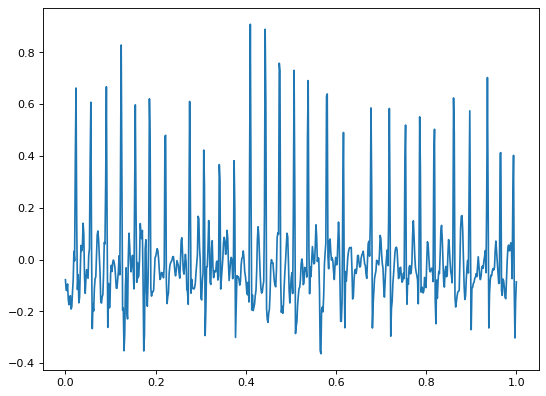

In [ ]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
dt = 1/64
t = np.linspace(0, 1, 640)
plt.plot(t, signals[0, 640:1280] )

In [ ]:
acc = np.sum((signals[1, :], signals[2,:], signals[3,:]), axis=0)

In [ ]:
acc = np.divide(acc, 3)

In [ ]:
signals_two_chan = np.vstack((signals[0,:], acc))

In [ ]:
import numpy as np
signals = np.load('data/training1/signals_two_chan.npy')
#signals_two_chan_split = split_window(signals, 320)
#np.save('data/training1/signals_two_chan_split', signals_two_chan_split)

In [ ]:
def split_window(sig, window_len): 
        sig = sig.T
        n_windows = int(np.floor(sig.shape[0])/( window_len)) 
        #print(n_windows, 'n windows')
        j = 0
        n_channels = sig.shape[1]
        #print(n_channels, 'n channels')
        #initiate an array for signal chunks storage filled up with zeros
        sig_chunks = np.zeros(((n_windows, window_len, n_channels)))
        #label_chunks = np.zeros((self.n_windows , self.window_len * self.freq, n_channels))
        label_chunks = np.zeros((n_windows , 1))
      
        for i in range(0, sig.shape[0], int(window_len)): 
            split = sig[i:i + int(window_len), :]
          
            # Signal chunk too short 
            if len(split) < int(window_len): 
                break
            
            else:
                sig_chunks[j] = split
                j +=1            
        return sig_chunks
    
    

In [ ]:
cd drive/MyDrive/'Colab Notebooks'/ewelina_ssl/

In [5]:
    #!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 28 12:25:33 2022

@author: ewelina
"""

#import numpy as np
import math
import cv2
#from data_loader import sig_chunks, label_chunks
import tensorflow as tf
import numpy as np
import warnings
#import tensorflow.experimental.numpy as np
warnings.filterwarnings("ignore")


def add_noise(signal, noise_amount):
    
   a =0
    
   noise = np.random.normal(1, noise_amount, np.shape(signal)[0])
   noised_signal = signal+noise
   return noised_signal

def add_noise_with_SNR(signal, noise_amount):
   """ 
   adding noise  created using: https://stackoverflow.com/a/53688043/10700812 

   """
   target_snr_db = noise_amount #20
   x_watts = signal ** 2                       # Calculate signal power and convert to dB 
   sig_avg_watts = np.mean(x_watts)
   sig_avg_db = 10 * np.log10(sig_avg_watts)   # Calculate noise then convert to watts
   noise_avg_db = sig_avg_db - target_snr_db
   noise_avg_watts = 10 ** (noise_avg_db / 10)
   mean_noise = 0
   noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))     # Generate an sample of white noise
   noised_signal = signal + noise_volts        # noise added signal

   return noised_signal 


def scaled(signal, factor):
   """"
   scale the signal
   """
   scaled_signal = signal * factor
   return scaled_signal
 
def negate(signal):
   """ 
   negate the signal 
   """
   negated_signal = signal * (-1)
   return negated_signal

def hor_filp(signal):
   """ 
   flipped horizontally 
   """
   hor_flipped = np.flip(signal)
   return hor_flipped

def permute(signal, pieces):
   """ 
   signal: numpy array (batch x window)
   pieces: number of segments along time    
   """
   pieces       = int(np.ceil(np.shape(signal)[0]/(np.shape(signal)[0]//pieces)).tolist())
   piece_length = int(np.shape(signal)[0]//pieces)
    
   sequence = list(range(0,pieces))
   np.random.shuffle(sequence)
    
   permuted_signal = np.reshape(signal[:(np.shape(signal)[0]//pieces*pieces)], (pieces, piece_length)).tolist() + [signal[(np.shape(signal)[0]//pieces*pieces):]]
   permuted_signal = np.asarray(permuted_signal)[sequence]
   permuted_signal = np.hstack(permuted_signal)
        
   return permuted_signal

def time_warp(signal, sampling_freq, pieces, stretch_factor, squeeze_factor):
   """ 
   signal: numpy array (batch x window)
   sampling freq
   pieces: number of segments along time
   stretch factor
   squeeze factor
   """
    
   total_time = np.shape(signal)[0]//sampling_freq
   segment_time = total_time/pieces
   sequence = list(range(0,pieces))
   stretch = np.random.choice(sequence, math.ceil(len(sequence)/2), replace = False)
   squeeze = list(set(sequence).difference(set(stretch)))
   initialize = True
   for i in sequence:
        orig_signal = signal[int(i*np.floor(segment_time*sampling_freq)):int((i+1)*np.floor(segment_time*sampling_freq))]
        orig_signal = orig_signal.reshape(np.shape(orig_signal)[0],1)
        if i in stretch:
            output_shape = int(np.ceil(np.shape(orig_signal)[0]*stretch_factor))
            new_signal = cv2.resize(orig_signal, (1, output_shape), interpolation=cv2.INTER_LINEAR)
            if initialize == True:
                time_warped = new_signal
                initialize = False
            else:
                time_warped = np.vstack((time_warped, new_signal))
        elif i in squeeze:
            output_shape = int(np.ceil(np.shape(orig_signal)[0]*squeeze_factor))
            new_signal = cv2.resize(orig_signal, (1, output_shape), interpolation=cv2.INTER_LINEAR)
            if initialize == True:
                time_warped = new_signal
                initialize = False
            else:
                time_warped = np.vstack((time_warped, new_signal))
   return time_warped
  
transform_task = np.array([0, 1, 2, 3, 4, 5, 6]) 
def make_batch(signal_batch, noise_amount, scaling_factor, permutation_pieces, time_warping_pieces, time_warping_stretch_factor, time_warping_squeeze_factor):
   """
   genrator to do signal transformation and then make a batch of 7 (+3 acc), which is a batch contains all transformed signal with original signal"""
   signal_batch = signal_batch.T
   total_batch = np.array([])
   total_labels = np.array([])
   transform_task = np.array([[0, 1, 2, 3, 4, 5, 6]]) 
   for i in range(2):
        
        signal = signal_batch[i,:] 
        #print(len(signal), 'length') 320   
        #print(signal.shape)  (320,) 
        if len(signal)<320:
            #print('length too short')
            continue
        else:
            #signal              = np.trim_zeros(signal, 'b')
            sampling_freq       = np.int(64)
            noised_signal       = add_noise_with_SNR(signal, noise_amount = noise_amount) #round(np.random.uniform(0.005,0.05),2)) # 0.005 - 0.05
            scaled_signal       = scaled(signal, factor = scaling_factor) #round(np.random.uniform(0.2,2),2)) # 0.2 - 2
            negated_signal      = negate(signal)
            flipped_signal      = hor_filp(signal)
            permuted_signal     = permute(signal, pieces = permutation_pieces) # 2-20
            time_warped_signal  = time_warp(signal, sampling_freq, pieces = time_warping_pieces, stretch_factor = time_warping_stretch_factor, squeeze_factor = time_warping_squeeze_factor)
      
            tw_start_index      = np.int(np.random.randint(0, abs((len(time_warped_signal)-len(signal)))))
            tw_stop_index       = np.int(tw_start_index + len(signal))
            time_warped_signal  = time_warped_signal[tw_start_index:tw_stop_index]
      
            signal                  = signal.reshape(1, len(signal))
            noised_signal           = noised_signal.reshape(1, len(noised_signal))
            scaled_signal           = scaled_signal.reshape(1, len(scaled_signal))
            negated_signal          = negated_signal.reshape(1, len(negated_signal))
            flipped_signal          = flipped_signal.reshape(1, len(flipped_signal))
            permuted_signal         = permuted_signal.reshape(1, len(permuted_signal))
            time_warped_signal      = time_warped_signal.reshape(1, len(time_warped_signal))
                          
            batch = np.array([signal, noised_signal, scaled_signal, negated_signal, flipped_signal, permuted_signal, time_warped_signal])
            labels = transform_task
            ## padding the transformed signal batch 
            #batch = tf.keras.preprocessing.sequence.pad_sequences(batch, dtype='float32', padding='post')
            #print(batch.shape, 'batch')
            total_batch = np.concatenate((total_batch, batch.T), axis=1) if total_batch.size else batch.T
            #print(total_batch.shape, 'total batch')
            total_labels = np.concatenate((total_labels, labels), axis=0) if total_labels.size else labels
            #total batch  (14, 320, 1) (1, 14)
  
   return total_batch, total_labels

def make_total_batch(signal_batch, noise_amount, scaling_factor, permutation_pieces, time_warping_pieces, time_warping_stretch_factor, time_warping_squeeze_factor):
   """ calling make_batch from here, when batch size is more than one, like 64 or 32, it will make actual batch size = batch_size * len(transformed signal)
   """
   #(2576167, 320, 2)
   #steps = length // batchsize +1
   steps = signal_batch.shape[0]
   all_sig = np.zeros((steps, 320, 2, 7))
   all_labels = np.zeros((signal_batch.shape[0], 2, 7))
   for counter in range(steps):
        
        total_batch, total_labels =  make_batch(signal_batch[counter, :, :], noise_amount, scaling_factor, permutation_pieces, time_warping_pieces, time_warping_stretch_factor, time_warping_squeeze_factor)
        all_sig[counter, :, :, :] = total_batch
        #total_labels = total_labels.reshape(1, signal_batch.shape[2], 7)
        all_labels[counter, :, :] = total_labels
        #all_labels = np.vstack((all_labels, total_labels))
     
   return all_sig, all_labels
   #yield total_batch, total_labels

## transformation task params
noise_param = 15 #noise_amount
scale_param = 1.1 #scaling_factor
permu_param = 20 #permutation_pieces
tw_piece_param = 9 #time_warping_pieces
twsf_param = 1.05 #time_warping_stretch_factor
time_warping_squeeze_factor= 1/twsf_param
no_of_task = ['original_signal', 'noised_signal', 'scaled_signal', 'negated_signal', 'flipped_signal', 'permuted_signal', 'time_warped_signal'] 
transform_task = [0, 1, 2, 3, 4, 5, 6] #transformation labels
single_batch_size = len(transform_task)

'''

x, y  = make_total_batch(all_signals, noise_param, scale_param, permu_param, tw_piece_param, twsf_param, time_warping_squeeze_factor)
np.save('data/training1/x', x)
np.save('data/training1/y', y)

'''
sig_split = np.load('data/training1/sig_split.npy')
n = sig_split.shape[0]/100
print(n, sig_split.shape)
inputs = np.array([])
targets = np.array([])

for i in range (60, 100):

  idx = int(n*i)
  idx2= int(n*(i+1))
  #print(idx, idx2)
  print(i)
  x, y  = make_total_batch(sig_split[idx:idx2, :, :], noise_param, scale_param, permu_param, tw_piece_param, twsf_param, time_warping_squeeze_factor)
  #print(x.shape, 'x shape', y.shape, 'y_shape')
  
  inputs = np.concatenate((inputs, x), axis =0) if inputs.size else x
  targets = np.concatenate((targets, y), axis= 0) if targets.size else y
  print(inputs.shape, targets.shape)

  

np.save('data/training1/inputs3', inputs)
np.save('data/training1/targets3', targets)



12880.84 (1288084, 320, 2)
60
(12881, 320, 2, 7) (12881, 2, 7)
61
(25762, 320, 2, 7) (25762, 2, 7)
62
(38642, 320, 2, 7) (38642, 2, 7)
63
(51523, 320, 2, 7) (51523, 2, 7)
64
(64404, 320, 2, 7) (64404, 2, 7)
65
(77285, 320, 2, 7) (77285, 2, 7)
66
(90166, 320, 2, 7) (90166, 2, 7)
67
(103047, 320, 2, 7) (103047, 2, 7)
68
(115927, 320, 2, 7) (115927, 2, 7)
69
(128808, 320, 2, 7) (128808, 2, 7)
70
(141689, 320, 2, 7) (141689, 2, 7)
71
(154570, 320, 2, 7) (154570, 2, 7)
72
(167451, 320, 2, 7) (167451, 2, 7)
73
(180332, 320, 2, 7) (180332, 2, 7)
74
(193213, 320, 2, 7) (193213, 2, 7)
75
(206093, 320, 2, 7) (206093, 2, 7)
76
(218974, 320, 2, 7) (218974, 2, 7)
77
(231855, 320, 2, 7) (231855, 2, 7)
78
(244736, 320, 2, 7) (244736, 2, 7)
79
(257617, 320, 2, 7) (257617, 2, 7)
80
(270498, 320, 2, 7) (270498, 2, 7)
81
(283378, 320, 2, 7) (283378, 2, 7)
82
(296259, 320, 2, 7) (296259, 2, 7)
83
(309140, 320, 2, 7) (309140, 2, 7)
84
(322021, 320, 2, 7) (322021, 2, 7)
85
(334902, 320, 2, 7) (334902, 2, 7)

In [ ]:
inputs

In [14]:
print(y[0, 0, :])

[0. 1. 2. 3. 4. 5. 6.]


In [3]:
import numpy as np
signals_two_chan_split = np.load('data/training1/signals_two_chan_split.npy')
print(signals_two_chan_split.shape)

(2576167, 320, 2)


In [4]:
sig_split = signals_two_chan_split[::2, :, :]
print(sig_split.shape)
np.save('data/training1/sig_split', sig_split)

(1288084, 320, 2)


In [ ]:
import numpy as np
#loading the first dataset
inputs = np.load('data/training1/x_two_chan.npy0.npy')
targets = np.load('data/training1/y_two_chan.npy0.npy')      
for i in range(20, 32):
  x = np.load('data/training1/x_two_chan.npy'+str(i)+'.npy')
  y = np.load('data/training1/y_two_chan.npy'+str(i)+'.npy')
  inputs = np.concatenate((inputs, x), axis =0 )
  targets = np.concatenate((targets, y), axis = 0)
  print(i, inputs.shape, targets.shape)

np.save('data/training1/inputs', inputs)
np.save('data/training1/targets', targets)


20 (51523, 320, 7) (51523, 2, 7)
21 (77284, 320, 7) (77284, 2, 7)
22 (103046, 320, 7) (103046, 2, 7)
23 (128808, 320, 7) (128808, 2, 7)
24 (154569, 320, 7) (154569, 2, 7)
25 (180331, 320, 7) (180331, 2, 7)
26 (206093, 320, 7) (206093, 2, 7)
27 (231854, 320, 7) (231854, 2, 7)
28 (257616, 320, 7) (257616, 2, 7)
29 (283378, 320, 7) (283378, 2, 7)
30 (309139, 320, 7) (309139, 2, 7)
31 (334901, 320, 7) (334901, 2, 7)


In [ ]:
import numpy as np
signals_two_chan_split = np.load('data/training1/signals_two_chan_split.npy')


In [ ]:
signals_two_chan_split.shape[0]/201

12816.751243781095

# New section

In [ ]:
cd drive/MyDrive/'Colab Notebooks'/ewelina_ssl/

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/ewelina_ssl/'
/content


In [3]:
import numpy as np


inputs = np.load('data/training1/inputs.npy')
targets = np.load('data/training1/targets.npy') 
#targets = np.swapaxes(targets, 2,1)

  


split acc and ecg into separate chunks

In [5]:
targets.shape

(334901, 2, 7)

In [ ]:
inputs_ecg = inputs[:, :320, 7:14]

In [ ]:
inputs_acc1 = inputs[:, :320, :7]
inputs_acc2 = inputs[:, :320, 14:21]
inputs_acc3 = inputs[:, :320, 21:]
inputs = np.concatenate((inputs_ecg, inputs_acc1, inputs_acc2, inputs_acc3), axis=2)

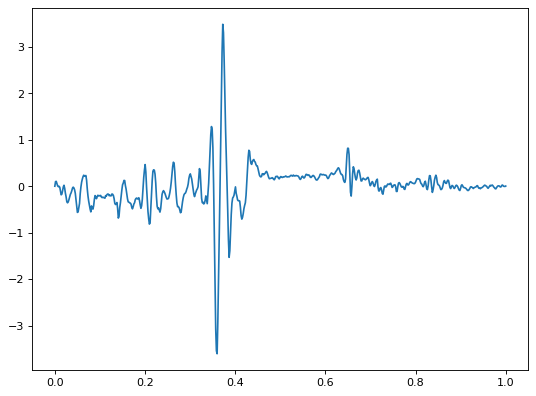

In [ ]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
dt = 1/64
t = np.linspace(0, 1, 640)
plt.plot(t, inputs[0, :, 13] )

In [ ]:
targ_ecg = targets[:, 0, :]

treaining model, datashape : n, 4, 7
4 dense layers

```
# This is formatted as code
```



treaining model, datashape : n, 7, 4
7 dense layers.  works less 

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


transfer learning

In [6]:
import tensorflow as tf
import keras
import os
import numpy as np
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Conv1D, BatchNormalization, Dropout, Input, MaxPooling1D, Flatten, MaxPooling2D
from keras.optimizers import SGD
from tensorflow.keras import layers
import torch

def conv_block(x, filter_size, kernel_size, stride, batch_norm, dropout_rate, name, trainable):
    
    reuse = tf.compat.v1.AUTO_REUSE
    conv  = Conv1D(filters = filter_size, kernel_size = kernel_size, strides = stride, padding ='same',  name = name, trainable = trainable)(x)
    if batch_norm:
        conv    = BatchNormalization(conv)
    conv     = tf.nn.leaky_relu(conv)
    if dropout_rate:
        conv    = Dropout(conv, dropout_rate)
    
    return conv

def dense_block(x, hidden_nodes, dropout_rate, name, trainable):
    
    reuse = tf.compat.v1.AUTO_REUSE
    dense       = Dense(hidden_nodes, name=name, trainable = trainable)(x)
    #print(dense.shape)
    dense       = tf.nn.leaky_relu(dense)
    #print(dense.shape)
    dense       = Dropout(0.2)(dense)
    
    return dense


def lstm(x, name, return_sequences, trainable):
    reuse = tf.compat.v1.AUTO_REUSE
    lstm  = tf.keras.layers.LSTM(150, return_sequences=return_sequences, trainable=trainable, name = name)(x)
    #lstm  = Dropout(dropout_rate)(lstm)

    return lstm


def build_ssl2_model(trainable):
    filter_size = 32
    kernel_size = 32
    batch_norm= False
    hidden_nodes = 128
    stride = 1
    kernel_size = 32
    stride_mp = 4
    pool_size = (2)
    dropout = 0.45
    dropout_rate = torch.tensor(dropout, dtype=torch.int8)
    
    if trainable:
        inputs = layers.Input(shape=(320, 2, 7))
    else:
        inputs = layers.Input(shape=(320, 4))    
        ## conv block 1
    conv1     = conv_block(inputs, filter_size, kernel_size, stride, batch_norm, dropout_rate,  name = 'conv10', trainable = trainable) 
    print(conv1.shape, 'conv11')
    conv1     = conv_block(conv1,  filter_size*2, kernel_size, stride , batch_norm, dropout_rate,  name ='conv11', trainable = trainable)
    print(conv1.shape, 'conv12')
    conv1     = MaxPooling1D(pool_size = pool_size, strides=stride_mp, padding='valid',  name='mp1')(conv1)   
    #conv1     = Flatten()(conv1)
    print('conv1', conv1.shape)
            
    conv2     = conv_block(conv1,  filter_size*2, kernel_size , stride, batch_norm, dropout_rate,  name = 'conv20', trainable = trainable) 
    conv2     = conv_block(conv2,  filter_size*4, kernel_size, stride, batch_norm, dropout_rate,  name ='conv21', trainable = trainable) 
    conv2     = MaxPooling1D(pool_size = pool_size, strides=stride_mp, padding='valid', name = 'mp2')(conv2)    
    #conv2     = Flatten()(conv2)
    #print('conv2', conv2.shape)
            
    conv3     = conv_block(conv2,  filter_size*4, kernel_size, stride, batch_norm, dropout_rate,  name = 'conv30', trainable = trainable) 
    conv3     = conv_block(conv3,  filter_size*8, kernel_size, stride, batch_norm, dropout_rate,  name = 'conv31', trainable = trainable) 
    conv3     = MaxPooling1D(pool_size = pool_size, strides=stride_mp, padding='valid',  name ='mp3')(conv3)    
    #conv3     = Flatten(name='flatten')(conv3)
    print(conv3.shape, 'conv3')

    print(conv3.shape)

  
    lstm1       = lstm(conv3,  'lstm1', True, trainable= True)
    print(lstm1.shape)
    lstm2       = lstm(lstm1, 'lstm2', False, trainable = True)

    if trainable:

      #print(lstm2.shape, 'lstm 2')
      dense11      = dense_block(lstm2, hidden_nodes,  dropout_rate, name='dense11', trainable = trainable)
      dense12      = dense_block(dense11, 64,  dropout_rate,  name='dense12', trainable = trainable) 
      dense13      = Dense(units=7, name='dense1', trainable = trainable)(dense12)
      print(dense13.shape, 'dense13')

      dense21      = dense_block(lstm2, hidden_nodes,  dropout_rate,  name='dense21', trainable = trainable)
      dense22      = dense_block(dense21, 64, dropout_rate,  name='dense22', trainable = trainable) 
      dense23      = Dense(units=7, name='dense2', trainable = trainable)(dense22)

      '''dense31      = dense_block(lstm2, hidden_nodes,  dropout_rate,  name='dense31', trainable = trainable)
      dense32      = dense_block(dense31, 64,  dropout_rate, name='dense32', trainable = trainable) 
      dense33      = Dense(units=7, name='dense3', trainable = trainable)(dense32)

      dense41      = dense_block(lstm2, hidden_nodes, dropout_rate,  name='dense41', trainable = trainable)
      dense42      = dense_block(dense41, 64,  dropout_rate, name='dense42', trainable = trainable) 
      dense43      = Dense(units=7, name='dense4', trainable = trainable)(dense42)'''


      outputs = tf.convert_to_tensor([dense13, dense23])
      #n case of multiclass classification, we use the softmax activation at the output
      #outputs = tf.convert_to_tensor(dense13)
      outputs = tf.nn.softmax(outputs)
      print(outputs)
      outputs = tf.transpose(outputs, [1, 0, 2])
    
    else:
      dense1      = dense_block(lstm2, hidden_nodes, dropout_rate, name='dense1', trainable = True)
      dense2      = dense_block(dense1, 64, dropout_rate, name='dense2', trainable = True) 
      dense3      = Dense(units=1, name='dense30', trainable = True)(dense2)
      #sigmoid is applied for binary classification
      outputs = tf.nn.sigmoid(dense3)
      print('outputs', outputs)
   
      outputs = tf.nn.sigmoid(dense3)
             
    model = tf.keras.Model(inputs, outputs, name='ssl')   
    return model
   


In [7]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import _pickle as cPickle
from matplotlib.pyplot import figure
# model import build_ssl_model


def train(model, MAX_EPOCHS, x, y):
        
        tf.random.set_seed(42)
        model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(0.00002), 
                                 metrics=[tf.keras.metrics.CategoricalAccuracy()])
        
        checkpoint_path = "model/cp.ckpt"
        checkpoint_dir = os.path.dirname(checkpoint_path)

        # Create a callback that saves the model's weights
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

        history = model.fit(x, y, epochs=MAX_EPOCHS, validation_split=0.2, batch_size=25, verbose = 2)

        #saving model and history
        np.save('history/history1.npy',history.history)

        print('saving model')
        model.save('saved_model/model1')
        print('saved model: saved_model/model1')

        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = MAX_EPOCHS

        plt.figure()
        plt.plot(epochs, loss, 'r', label='Training loss')
        plt.plot(epochs, val_loss, 'bo', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss Value')
        plt.ylim([0, 1])
        plt.legend()
        plt.show()


        print('saved model: saved_model/model')
        with open(r"saved_model/model.pickle", "wb") as output_file:
          cPickle.dump(model, output_file)
    
ssl_model = build_ssl2_model(trainable=True)



(None, 320, 2, 32) conv11
(None, 320, 2, 64) conv12


ValueError: ignored

In [ ]:
inputs.shape

(334901, 320, 7)

In [ ]:
ssl_model = build_ssl2_model(trainable = True)

targets = targets.reshape(inputs.shape[0], 14)
MAX_EPOCHS = 5
train(ssl_model, MAX_EPOCHS, inputs, targets)

<ipython-input-8-30a180a8c46d>:55: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  dropout_rate = torch.tensor(dropout, dtype=torch.int8)


(None, 320, 32) conv11
(None, 320, 64) conv12
conv1 (None, 80, 64)
(None, 5, 256) conv3
(None, 5, 256)
(None, 5, 150)
(None, 7) dense13
KerasTensor(type_spec=TensorSpec(shape=(2, None, 7), dtype=tf.float32, name=None), name='tf.nn.softmax_3/Softmax:0', description="created by layer 'tf.nn.softmax_3'")


ValueError: ignored

In [ ]:
x_train =np.load('data/x_train.npy')
y_train=np.load('data/y_train.npy')
x_val =np.load('data/x_val.npy')
y_val =np.load('data/y_val.npy')



In [ ]:
x = np.concatenate((x_train, x_val))
y = np.concatenate((y_train, y_val))

In [ ]:
x.shape

(3118, 320, 4)

In [ ]:

model_target = build_ssl2_model(trainable = False)
model_target.summary()

(None, 320, 32) conv11
(None, 320, 64) conv12
conv1 (None, 80, 64)
(None, 5, 256) conv3
(None, 5, 256)
(None, 5, 150)
outputs KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='tf.math.sigmoid/Sigmoid:0', description="created by layer 'tf.math.sigmoid'")
Model: "ssl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 320, 4)]          0         
                                                                 
 conv10 (Conv1D)             (None, 320, 32)           4128      
                                                                 
 tf.nn.leaky_relu_14 (TFOpLa  (None, 320, 32)          0         
 mbda)                                                           
                                                                 
 conv11 (Conv1D)             (None, 320, 64)           65600     
                                     

In [ ]:
import _pickle as cPickle
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

'''with open(r"saved_model/model.p", "rb") as input_file:
  model_source = cPickle.load(input_file)'''

model_source =tf.keras.models.load_model('saved_model/model')

model_target = build_ssl2_model(trainable = False)
# copy weights from one model to another model    
def copyModel2Model(model_source, model_target, certain_layer=""):        
    
    for l_target, l_source in zip(model_target.layers, model_source.layers):
  
        # Loads the weights
        #model_source.load_weights(checkpoint_path)
        if l_source.name=='conv10':
          pass
        else:
          weights = l_source.get_weights()
          l_target.set_weights(weights)
          print(l_target.name) 
          if l_source.name.startswith('mp3'):
              print(l_source.name)
              break
    print("model source was copied into model target")    
      
'''for layer in model.layers[:175]:
  layer.trainable = False'''

copyModel2Model(model_source, model_target, certain_layer='lstm1' )

def train(x, y, model, MAX_EPOCHS):
    
    tf.random.set_seed(42)

    model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(0.001), 
                                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])
            
    history = model.fit(x, y, epochs=MAX_EPOCHS, validation_split=0.2, batch_size=10, verbose = 2)

       
    #saving model and history
    np.save('history/history2.npy',history.history)

    print('saving model')
    model.save('saved_model/model2')
    print('saved model: saved_model/model2')

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    print('loss shape', loss)

    epochs = MAX_EPOCHS

    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'bo', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

MAX_EPOCHS = 150
train(x, y, model_target, MAX_EPOCHS)
#grid search ..


(None, 320, 32) conv11
(None, 320, 64) conv12
conv1 (None, 80, 64)
(None, 5, 256) conv3
(None, 5, 256)
(None, 5, 150)
outputs KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='tf.math.sigmoid_4/Sigmoid:0', description="created by layer 'tf.math.sigmoid_4'")
input_5
tf.nn.leaky_relu_44


ValueError: ignored

In [ ]:
#Loasding labeled samples


import numpy as np
import h5py
import pandas as pd
import os
from torch.utils.data import TensorDataset, DataLoader
import unisens
import scipy
import matplotlib as plt
import math
import matplotlib.pyplot as plt
import heartpy as hp
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader
import pickle
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


def load_and_save_data(subject):
    first = True
    final_signal = 0
    final_labels = 0
    idx = 0
    firstIdx = True
    sig_chunks = []
    label_chunks=[]    
   
    path_of_rawdata_folder = "data/raw/signal"
    path_of_rawanno_folder = "data/raw/annotations"
    records = os.listdir(path_of_rawdata_folder + "/" + subject)
    #print('records', records)

    if '.DS_Store' in records:
        records.remove('.DS_Store')
        #print('DS removed', records)
   
    elif '._.DS_Store' in records:
         records.remove('.DS_Store')
         #print('DS removed', records)
         
    for record in records:
            if record[0:2] =='._':
                #ecords.remove(record)
                continue
                #print('record removed: ', record)
            #print(record)
            records2 = os.listdir(path_of_rawdata_folder + "/" + subject + "/" + record + "/")
            #print('record through', record)
            
            if '.DS_Store' in records2:
                records2.remove('.DS_Store')
            if '._.DS_Store' in records2:
                records2.remove('._.DS_Store')
           
            #print('RECORDS2', records2)
            for record2 in records2:
                    if record2[0:2] =='._':
                        #ecords2.remove(record2)
                        #print('._ remove', record2)
                        continue
                    else:
                      annotation_path = path_of_rawanno_folder + "/" +  subject + "/" + record + "/" + record2
                      if os.stat(annotation_path + "/annotation.csv",).st_size == 0: #check if annotation exist
                                continue
                      else:
                        ecg_path = path_of_rawdata_folder + "/"  + subject + "/" + record + "/" + record2
                        annotation_path = path_of_rawanno_folder + "/" +  subject + "/" + record + "/" + record2
                        #print(ecg_path)
                        if os.path.exists(ecg_path):
                            #print('path exists')
                            u = unisens.Unisens(ecg_path, readonly=True) 
                                                    
                            signal = u['ecg.bin']  # Read the ECG signal from bin file
                            data_ecg = signal.get_data()
                            data_ecg = data_ecg[0]  # Final numpy array containing full days record
                            
                            #filtering signals
                            bandpass_signal = hp.filter_signal(data_ecg, cutoff=[.5, 45], sample_rate=1024, order=3, filtertype='bandpass')
                            filtered_signal = hp.smooth_signal(bandpass_signal, sample_rate=1024, polyorder=6)
                            #print(filtered_signal.shape, 'shape of filtered signal')
                            #downsample ecg data 1024 Hz --> 64 Hz
                            data_ecg = filtered_signal[0::16]
                            #rint(data_ecg.shape, 'data ecg shape')
                           
                            acc = u['acc.bin']  # Read the ECG signal from bin file
                            data_acc = acc.get_data()
                            #rint(data_acc.shape, 'data acc shape')
                            #data_acc_full = np.repeat(data_acc, 16, axis=1)
                            if data_ecg.shape[0] > data_acc.shape[1]:
                                    data_ecg = data_ecg[:data_acc.shape[1]]
                            
                            if data_ecg.shape[0] < data_acc.shape[1]:
                                data_acc = data_acc[:, :data_ecg.shape[0]]
                                    
                            df = np.vstack((data_ecg, data_acc))
                            if first == True:
                                final_signal = df
                                first = False
                              
                            else:
                                final_signal = np.hstack((final_signal, df))
                            #annotations'''
                      
                    
                            labels  = pd.read_csv(annotation_path + "/annotation.csv", header=0)
                            for index, row in labels.iterrows():
                                    
                                        #print(str(row[0]) + " " + str(row[1]) + " " + str(row[2]), all_labels.shape, 'shape labels')
                                        start_point = int(row[0]/16)  # start index  of 10 seconds segemt  in annotation.csv file of each record
                                        end_point = int(row[1]/16) # end index  of 10 seconds segemt  in annotation.csv
                                        annotation = row[2]  # Class label  for the 10 seconds
                                        mid_point = int(start_point + int(320))
                                        if (annotation == 1): #AF
                                          anno = 1
                                        elif (annotation !=1):
                                          anno = 0
                                       #print(start_point, end_point)
                                        length = end_point - start_point
                                        #label_fragment = np.full(length, annotation, dtype=np.int32)  # make 1 for the length of the signal
                                        #all_labels[start_point:end_point] = annotation
                                        df = df.T
                                        sig_chunks.append(df[start_point:mid_point, :])
                                        label_chunks.append(anno)
                                        sig_chunks.append(df[mid_point:end_point, :])
                                        label_chunks.append(anno)

                                        df = df.T
                              
    return sig_chunks, label_chunks   


#load data of different patients!
path_of_rawdata_folder = "data/raw/signal"
path_of_rawanno_folder = "data/raw/annotations"

listOfSubjects = os.listdir(path_of_rawdata_folder)
all_labeled_signals=[]
all_labels=[]
    
if '.DS_Store' in listOfSubjects:
    listOfSubjects.remove('.DS_Store')
if '._.DS_Store' in listOfSubjects:
    listOfSubjects.remove('._.DS_Store')  

if 'P16' in listOfSubjects:
    listOfSubjects.remove('P16')
    
i=0
for subject in listOfSubjects:
    print('subject', subject)
    if subject.startswith('._'):
        listOfSubjects.remove(subject)  
        
    else:
        print(subject)
        signals, labels = load_and_save_data(subject) 
        all_labeled_signals.append(signals)
        all_labels.append(labels)


subject PNSR-4
PNSR-4
subject PNSR-3
PNSR-3
subject P1
P1


KeyboardInterrupt: ignored

non trainable, no transfer learning : [1.0063937902450562, 0.39344263076782227] score


[1.0207167863845825, 0.39344263076782227] score non trainable, transfer learning

In [ ]:
import numpy as np
np.unique(y_val)


array([1., 2., 3.])

In [ ]:
#try binary
#try 5 sec

print(y_val.shape, x_val.shape)
print(y_train.shape, x_train.shape)

(175, 1) (175, 320, 4)
(699, 1) (699, 320, 4)


In [ ]:
np.where(y_train==3)

(array([124, 125, 126, 127, 128, 129, 130, 131, 134, 135, 136, 137, 138,
        172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
        185, 186, 259, 260, 261, 262, 373, 415, 416]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

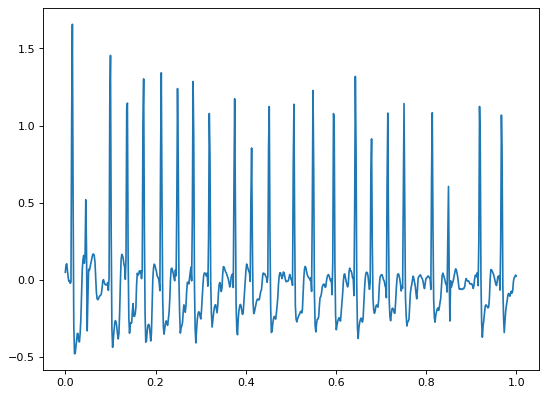

In [ ]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
dt = 1/64
t = np.linspace(0, 1, 640)
plt.plot(t, x_val[0, :, 0] )


In [ ]:
model_history = np.load('history/history.npy')
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(150)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

ValueError: ignored

In [ ]:
def encoder(input_encoder):
     
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    # Block 1
    x = layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    
    # Block 2
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    # Block 3
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
     
    # Block 4
    x = layers.Conv2D(64, 3, 1, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
     
    # Final Block
    flatten = layers.Flatten()(x)
    bottleneck = layers.Dense(2, name='dense_1')(flatten)
    model = tf.keras.Model(inputs, bottleneck, name="Encoder")
    return model

In [ ]:
pip install heartpy
pip install pyunisens
import numpy as np
import h5py
import pandas as pd
import os
from torch.utils.data import TensorDataset, DataLoader
import unisens
import scipy
import matplotlib as plt
import math
import matplotlib.pyplot as plt
import heartpy as hp
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader
import pickle
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


def load_and_save_data(subject):
    first = True
    final_signal = 0
    record_saved = False
    idx = 0
    firstIdx = True
    sig_chunks = []
    label_chunks=[]    
   
    path_of_rawdata_folder = "data/raw/signal"
    path_of_rawanno_folder = "data/raw/annotations"
    records = os.listdir(path_of_rawdata_folder + "/" + subject)
    #print('records', records)

    if '.DS_Store' in records:
        records.remove('.DS_Store')
        #print('DS removed', records)
   
    elif '._.DS_Store' in records:
         records.remove('.DS_Store')
         #print('DS removed', records)
         
    for record in records:
            if record_saved == True:
              break
            if record[0:2] =='._':
                #ecords.remove(record)
                continue
                #print('record removed: ', record)
            #print(record)
            records2 = os.listdir(path_of_rawdata_folder + "/" + subject + "/" + record + "/")

            record_saved = True
            #print('record through', record)
            
            if '.DS_Store' in records2:
                records2.remove('.DS_Store')
            if '._.DS_Store' in records2:
                records2.remove('._.DS_Store')
           
            #print('RECORDS2', records2)
            for record2 in records2:
                    if record2[0:2] =='._':
                        #ecords2.remove(record2)
                        #print('._ remove', record2)
                        continue
                    else:
                        ecg_path = path_of_rawdata_folder + "/"  + subject + "/" + record + "/" + record2
                        
                        if os.path.exists(ecg_path):
                            #print('path exists')
                            u = unisens.Unisens(ecg_path, readonly=True) 
                                                    
                            signal = u['ecg.bin']  # Read the ECG signal from bin file
                            data_ecg = signal.get_data()
                            data_ecg = data_ecg[0]  # Final numpy array containing full days record
                            
                            #filtering signals
                            bandpass_signal = hp.filter_signal(data_ecg, cutoff=[.5, 45], sample_rate=1024, order=3, filtertype='bandpass')
                            filtered_signal = hp.smooth_signal(bandpass_signal, sample_rate=1024, polyorder=6)
                            #print(filtered_signal.shape, 'shape of filtered signal')
                            #downsample ecg data 1024 Hz --> 64 Hz
                            data_ecg = filtered_signal[0::16]
                            #rint(data_ecg.shape, 'data ecg shape')
                           
                            acc = u['acc.bin']  # Read the ECG signal from bin file
                            data_acc = acc.get_data()
                            #rint(data_acc.shape, 'data acc shape')
                            #data_acc_full = np.repeat(data_acc, 16, axis=1)
                            if data_ecg.shape[0] > data_acc.shape[1]:
                                    data_ecg = data_ecg[:data_acc.shape[1]]
                            
                            if data_ecg.shape[0] < data_acc.shape[1]:
                                data_acc = data_acc[:, :data_ecg.shape[0]]
                                    
                            df = np.vstack((data_ecg, data_acc))
                            if first == True:
                                final_signal = df
                                first = False
                              
                            else:
                                final_signal = np.hstack((final_signal, df))
                              
    return final_signal


#load data of different patients!
path_of_rawdata_folder = "data/raw/signal"

listOfSubjects = os.listdir(path_of_rawdata_folder)
all_signals=[]
    
if '.DS_Store' in listOfSubjects:
    listOfSubjects.remove('.DS_Store')
if '._.DS_Store' in listOfSubjects:
    listOfSubjects.remove('._.DS_Store')  

if 'P16' in listOfSubjects:
    listOfSubjects.remove('P16')
    
i=0
for subject in listOfSubjects:
    print('subject', subject)
    if subject.startswith('._'):
        listOfSubjects.remove(subject)  
        
    else:
        print(subject)
        signals = load_and_save_data(subject)
        all_signals.append(signals)
        


subject P1
P1
subject PNSR-4
PNSR-4
subject PNSR-3
PNSR-3
subject P2
P2
subject P3
P3
subject P4
P4
subject P5
P5
subject P7
P7
subject P11
P11
subject P8
P8
subject P14
P14
subject P10
P10
subject P13
P13
subject P18
P18
subject P15
P15
subject P17
P17
subject P9
P9
subject P19
P19
subject P21
P21
subject P23
P23
subject P6
P6


In [ ]:
def decoder(input_decoder):
    # Initial Block
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(3136, name='dense_1')(inputs)
    x = tf.reshape(x, [-1, 7, 7, 64], name='Reshape_Layer')
     
    # Block 1
    x = layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
     
    # Block 2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    # Block 3
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
    
    # Block 4
    outputs = layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
def ae_loss(y_true, y_pred):
    loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return loss

NameError: ignored